In [1]:
import SimpleITK as sitk
import sys

from clinical_evaluation.utils import ops
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
patient_folder = Path("/home/suraj/Workspace/data/maastro/pairs_nrrd_registered/P0439C0006I13369619")

In [3]:
# Read Images from folder
CT = sitk.ReadImage(str(patient_folder /'source.nrrd'))
CBCT = sitk.ReadImage(str(patient_folder / 'target.nrrd'))

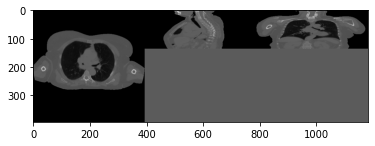

In [4]:
plt.imshow(ops.get_image_preview(CT), cmap='gray')

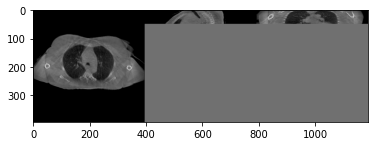

In [5]:
plt.imshow(ops.get_image_preview(CBCT), cmap='gray')

In [8]:
def _change_orientation(sitk_image, orient="LPS"):
    """
    Changes the underlying data array to desired orientation by changing the 
    Direction of the SITK Image
    """
    curr_filter = sitk.DICOMOrientImageFilter()
    curr_filter.SetDesiredCoordinateOrientation(orient)
    sitk_image = curr_filter.Execute(sitk_image)
    return sitk_image

In [9]:
# Change orientation to LSA as that's what RayStation looks at.
CT = _change_orientation(CT, orient="LSA")
CBCT = _change_orientation(CBCT, orient="LSA")

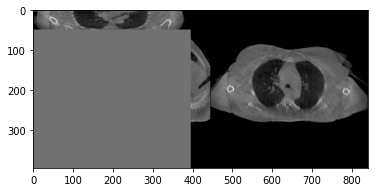

In [10]:
plt.imshow(ops.get_image_preview(CBCT), cmap='gray')

In [12]:
# Transformation matrix provided by Vicki from RS
matrix = np.array([
    [1, 0.01, 0.02, -1.06],
    [-0.01, 1.00, 0.00, -157.72],
    [-0.02, 0, 1, 23.68]])


In [13]:
translation_offset = matrix[:, 3]
rotation_matrix = matrix[:, :-1]


dimension = CT.GetDimension()
# Translation needs to be handled separately even if orientation is changed as it is not a part of sitk
# transformations applied to base-coordinate system: 
#Refer: https://simpleitk.readthedocs.io/en/master/fundamentalConcepts.html#transforms
sitk_translation = [-translation_offset[0], translation_offset[2], -translation_offset[1]]

# Convert cm to mm coordinates
translation = [v*10 for v in sitk_translation]

In [22]:
# Using affine transformation in SITK but the transformation done is Rigid. 
affine = sitk.AffineTransform(3)
affine.SetTranslation(translation)

# Set rotation
affine.SetMatrix(rotation_matrix.ravel())

In [23]:
deformed = sitk.Resample(CT, CBCT, affine.GetInverse(), sitk.sitkLinear, -1024,
                             CBCT.GetPixelID())

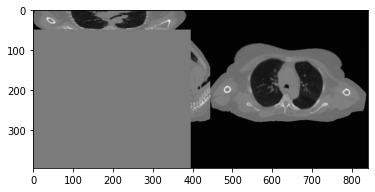

In [24]:
plt.imshow(ops.get_image_preview(deformed), cmap='gray')

In [25]:
# Convert orientation system back to LPS as that's what we use
deformed = _change_orientation(deformed, orient="LPS")

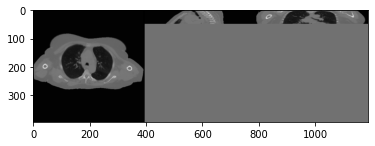

In [26]:
plt.imshow(ops.get_image_preview(deformed), cmap='gray')

In [27]:
sitk.WriteImage(deformed, 'deformed.nrrd')